[*********************100%***********************]  2 of 2 completed


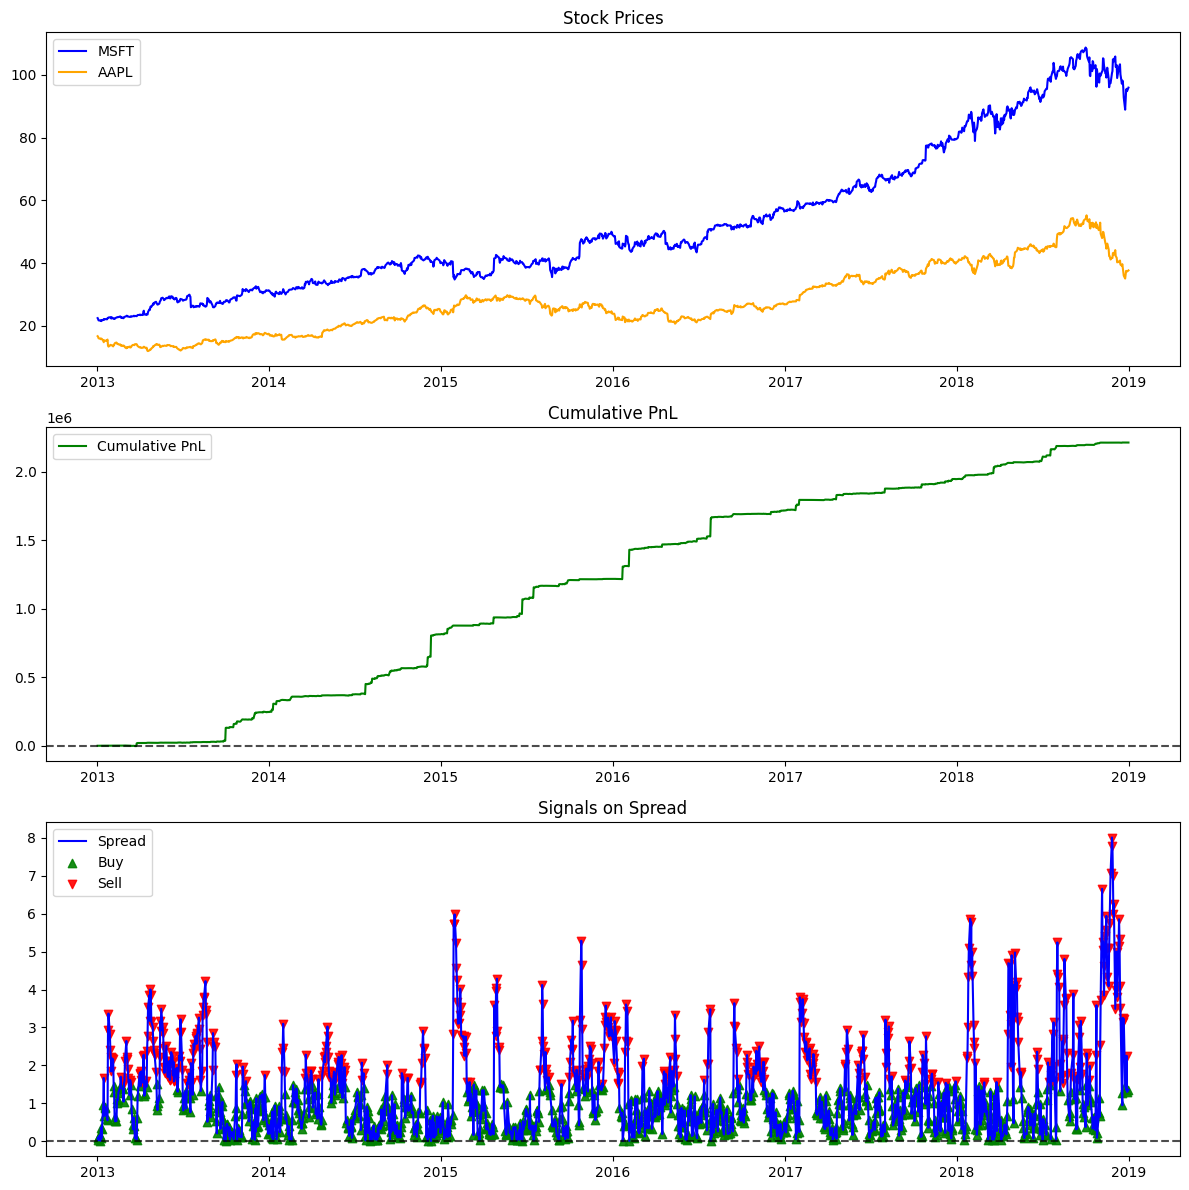

Final Cumulative PnL: 2212211.47


In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


def kalman_regression(prices1, prices2):
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack([np.asarray(prices1), np.ones(len(prices1))]).T[:, np.newaxis]
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov,
    )
    return kf.filter(np.asarray(prices2))[0]


def calculate_spread(price1, price2):
    means = kalman_regression(price2, price1)
    return pd.Series(abs(price1 - means[:, 0] * price2 - means[:, 1]), index=price1.index)


def stop_loss_condition(spread, threshold):
    return spread > threshold


def size_positions(spread, risk_factor):
    return (risk_factor / spread.rolling(window=30).std()).fillna(0)


def volatility_condition(spread, threshold):
    return spread.rolling(window=30).std() > threshold


def backtest(data, stock1, stock2, sl_threshold=2, rf=0.1, vt=0.02):
    spread = calculate_spread(data[stock1], data[stock2])
    buy = spread < 1.5
    sell = spread > 1.5
    sl = stop_loss_condition(spread, sl_threshold)
    vol = volatility_condition(spread, vt)
    pos_size = size_positions(spread, rf) * 10000
    ret = spread.pct_change().shift(-1).fillna(0)
    pos = np.zeros(len(spread))
    pos[buy] = 1
    pos[sell] = -1
    pos[sl] = 0
    pos[vol] = pos_size[vol]
    pnl = pos * ret
    cum_pnl = pnl.cumsum()
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 1, 1)
    plt.plot(data[stock1], label=stock1, color="blue")
    plt.plot(data[stock2], label=stock2, color="orange")
    plt.title("Stock Prices")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(cum_pnl, label="Cumulative PnL", color="green")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.title("Cumulative PnL")
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(spread.index, spread, label="Spread", color="blue")
    plt.scatter(spread.index[buy], spread[buy], marker="^", color="green", alpha=0.9, label="Buy")
    plt.scatter(spread.index[sell], spread[sell], marker="v", color="red", alpha=0.9, label="Sell")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.title("Signals on Spread")
    plt.legend()
    plt.tight_layout()
    plt.savefig("results.png")
    plt.show()
    return cum_pnl, pnl


tickers = ["MSFT", "AAPL"]
start_date, end_date = "2013-01-01", "2019-01-01"
data = yf.download(tickers, start=start_date, end=end_date)["Close"]
cum_pnl, pnl = backtest(data, "MSFT", "AAPL", sl_threshold=2, rf=0.1, vt=0.02)
print(f"Final Cumulative PnL: {cum_pnl.iloc[-1]:.2f}")
